#Installing PySpark

In [ ]:

!pip install pyspark findspark textblob nltk beautifulsoup4 requests matplotlib seaborn plotly
!pip install fake-useragent pandas wordcloud transformers torch
!pip install newspaper3k feedparser lxml


import findspark
findspark.init()


import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')

print("All dependencies installed successfully!")


All dependencies installed successfully!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Importing Necessary libraries

In [ ]:
import time
import random
import requests
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline

# Import PySpark SQL functions with explicit aliases
from pyspark.sql import functions as F
from pyspark.sql.functions import (
    col, avg, count, max as spark_max, min as spark_min,
    sum as spark_sum, when, hour, to_timestamp, stddev,
    desc, asc, lit, lower, upper, length, regexp_replace
)

from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import feedparser
from urllib.parse import urljoin, urlparse
import json
from IPython.display import clear_output, display, HTML
import threading
from queue import Queue
import gc

# Initialize Spark Session with optimized configuration
spark = SparkSession.builder \
    .appName("RealTimeNewsSentimentAnalysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

print("PySpark session initialized successfully!")
print(f"Spark version: {spark.version}")
print("All PySpark functions imported correctly!")


PySpark session initialized successfully!
Spark version: 3.5.1
All PySpark functions imported correctly!


In [ ]:


import builtins


min = builtins.min
max = builtins.max
sum = builtins.sum
abs = builtins.abs
all = builtins.all
any = builtins.any



##Configuring News Sources for Scraping

In [ ]:
NEWS_SOURCES = {
    'Times of India': {
        'rss': 'https://timesofindia.indiatimes.com/rssfeeds/-2128936835.cms',
        'base_url': 'https://timesofindia.indiatimes.com'
    },
    'Hindu': {
        'rss': 'https://www.thehindu.com/feeder/default.rss',
        'base_url': 'https://www.thehindu.com'
    },
    'Indian Express': {
        'rss': 'https://indianexpress.com/print/front-page/feed/',
        'base_url': 'https://indianexpress.com'
    },
    'NDTV': {
        'rss': 'https://feeds.feedburner.com/ndtvnews-top-stories',
        'base_url': 'https://www.ndtv.com'
    },
    'Economic Times': {
        'rss': 'https://economictimes.indiatimes.com/rssfeedstopstories.cms',
        'base_url': 'https://economictimes.indiatimes.com'
    },
    'News18': {
        'rss': 'https://www.news18.com/rss/india.xml',
        'base_url': 'https://www.news18.com'
    },
    'Zee News': {
        'rss': 'https://zeenews.india.com/rss/india-national-news.xml',
        'base_url': 'https://zeenews.india.com'
    },
    'Hindustan Times': {
        'rss': 'https://www.hindustantimes.com/rss/topnews/rssfeed.xml',
        'base_url': 'https://www.hindustantimes.com'
    }
}

# User agents for rotation
user_agents = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
]

def check_robots_txt(base_url):
    """Check robots.txt compliance"""
    try:
        robots_url = urljoin(base_url, '/robots.txt')
        response = requests.get(robots_url, timeout=5)
        if response.status_code == 200:

            content = response.text.lower()
            if 'crawl-delay:' in content:

                for line in content.split('\n'):
                    if 'crawl-delay:' in line:
                        try:
                            delay = int(line.split(':')[1].strip())
                            return max(delay, 2)
                        except:
                            return 5
            return 3
    except:
        pass
    return 5

def safe_request(url, headers, timeout=10):
    """Make a safe request with error handling"""
    try:
        time.sleep(random.uniform(1, 3))
        response = requests.get(url, headers=headers, timeout=timeout)
        response.raise_for_status()
        return response
    except requests.exceptions.RequestException as e:
        print(f"Request failed for {url}: {str(e)}")
        return None

def scrape_rss_feed(source_name, source_info, max_articles=10):
    """Scrape RSS feed with ethical considerations"""
    articles = []

    try:

        crawl_delay = check_robots_txt(source_info['base_url'])


        headers = {
            'User-Agent': random.choice(user_agents),
            'Accept': 'application/rss+xml, application/xml, text/xml',
            'Accept-Language': 'en-US,en;q=0.9',
            'Accept-Encoding': 'gzip, deflate',
            'DNT': '1',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1'
        }

        # Fetch RSS feed
        response = safe_request(source_info['rss'], headers)
        if not response:
            return articles

        # Parse RSS feed
        feed = feedparser.parse(response.content)

        for entry in feed.entries[:max_articles]:
            try:
                # Extract basic information
                title = entry.get('title', '').strip()
                description = entry.get('summary', entry.get('description', '')).strip()
                link = entry.get('link', '')
                pub_date = entry.get('published', '')

                if title and len(title) > 10:
                    articles.append({
                        'title': title,
                        'description': description,
                        'link': link,
                        'source': source_name,
                        'published_date': pub_date,
                        'scraped_at': datetime.now().isoformat(),
                        'content_length': len(title + " " + description)
                    })

                # Respect crawl delay
                time.sleep(crawl_delay)

            except Exception as e:
                print(f"Error parsing entry from {source_name}: {str(e)}")
                continue

    except Exception as e:
        print(f"Error scraping {source_name}: {str(e)}")

    return articles

def scrape_all_sources():
    """Scrape all news sources ethically"""
    all_articles = []

    for source_name, source_info in NEWS_SOURCES.items():
        try:
            print(f"Scraping {source_name}...")
            articles = scrape_rss_feed(source_name, source_info, max_articles=5)
            all_articles.extend(articles)

            # Wait between sources to be respectful
            time.sleep(random.uniform(2, 4))

        except Exception as e:
            print(f"Failed to scrape {source_name}: {str(e)}")
            continue

    print(f"Scraped {len(all_articles)} articles from {len(NEWS_SOURCES)} sources")
    return all_articles

print("News scraping functions defined successfully!")


News scraping functions defined successfully!


#Sentiment Analysis using VADER and TextBlob

In [ ]:

def analyze_sentiment_textblob(text):
    """Analyze sentiment using TextBlob"""
    if not text or len(text.strip()) < 3:
        return 'Neutral', 0.0, 0.0

    try:
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity

        if polarity > 0.1:
            sentiment = 'Positive'
        elif polarity < -0.1:
            sentiment = 'Negative'
        else:
            sentiment = 'Neutral'

        return sentiment, polarity, subjectivity
    except Exception as e:
        print(f"TextBlob error: {str(e)}")
        return 'Neutral', 0.0, 0.0

def analyze_sentiment_vader(text):
    """Analyze sentiment using VADER"""
    if not text or len(text.strip()) < 3:
        return 'Neutral', 0.0

    try:
        scores = sia.polarity_scores(text)
        compound = scores['compound']

        if compound >= 0.05:
            sentiment = 'Positive'
        elif compound <= -0.05:
            sentiment = 'Negative'
        else:
            sentiment = 'Neutral'

        return sentiment, compound
    except Exception as e:
        print(f"VADER error: {str(e)}")
        return 'Neutral', 0.0

def calculate_relevance_score(title, description):
    """Calculate relevance score based on keywords and content quality"""
    try:
        # Safely handle None values
        title_text = str(title) if title is not None else ""
        desc_text = str(description) if description is not None else ""
        text = (title_text + " " + desc_text).lower()

        # High-relevance keywords for Indian news
        high_relevance_keywords = [
            'government', 'minister', 'parliament', 'election', 'policy',
            'economy', 'market', 'covid', 'vaccine', 'healthcare',
            'education', 'technology', 'startup', 'investment', 'cricket',
            'bollywood', 'politics', 'modi', 'congress', 'bjp'
        ]

        # Medium-relevance keywords
        medium_relevance_keywords = [
            'india', 'indian', 'delhi', 'mumbai', 'bangalore', 'chennai',
            'business', 'finance', 'rupee', 'stock', 'gdp', 'inflation'
        ]

        score = 5.0  # Base score

        # Add points for high-relevance keywords
        for keyword in high_relevance_keywords:
            if keyword in text:
                score += 2.0

        # Add points for medium-relevance keywords
        for keyword in medium_relevance_keywords:
            if keyword in text:
                score += 1.0

        # Add points for content length (longer articles are often more relevant)
        content_length = len(title_text + desc_text)
        if content_length > 200:
            score += 2.0
        elif content_length > 100:
            score += 1.0

        # FIXED: Use explicit comparison instead of min() function
        return 20.0 if score > 20.0 else score

    except Exception as e:
        print(f"Relevance score error: {str(e)}")
        return 5.0

def safe_get_value(dictionary, key, default=""):
    """Safely get value from dictionary"""
    try:
        value = dictionary.get(key, default)
        return str(value) if value is not None else default
    except:
        return default

def process_articles_with_sentiment(articles):
    """Process articles and add sentiment analysis"""
    processed_articles = []

    print(f"Starting to process {len(articles)} articles...")

    for i, article in enumerate(articles):
        try:
            # Safely extract article information
            title = safe_get_value(article, 'title', '')
            description = safe_get_value(article, 'description', '')

            # Skip if both title and description are empty
            if not title.strip() and not description.strip():
                print(f"Skipping article {i+1}: Empty title and description")
                continue

            text_content = f"{title} {description}"

            # TextBlob sentiment analysis
            try:
                tb_sentiment, tb_polarity, tb_subjectivity = analyze_sentiment_textblob(text_content)
            except Exception as e:
                print(f"TextBlob failed for article {i+1}: {str(e)}")
                tb_sentiment, tb_polarity, tb_subjectivity = 'Neutral', 0.0, 0.0

            # VADER sentiment analysis
            try:
                vader_sentiment, vader_compound = analyze_sentiment_vader(text_content)
            except Exception as e:
                print(f"VADER failed for article {i+1}: {str(e)}")
                vader_sentiment, vader_compound = 'Neutral', 0.0

            # Calculate relevance score
            try:
                relevance_score = calculate_relevance_score(title, description)
            except Exception as e:
                print(f"Relevance calculation failed for article {i+1}: {str(e)}")
                relevance_score = 5.0

            # Combine sentiment scores for final sentiment
            try:
                combined_polarity = (tb_polarity + vader_compound) / 2

                if combined_polarity > 0.1:
                    final_sentiment = 'Positive'
                elif combined_polarity < -0.1:
                    final_sentiment = 'Negative'
                else:
                    final_sentiment = 'Neutral'
            except Exception as e:
                print(f"Sentiment combination failed for article {i+1}: {str(e)}")
                final_sentiment = 'Neutral'
                combined_polarity = 0.0

            # Create processed article dictionary
            processed_article = {
                'title': title,
                'description': description,
                'link': safe_get_value(article, 'link', ''),
                'source': safe_get_value(article, 'source', 'Unknown'),
                'published_date': safe_get_value(article, 'published_date', ''),
                'scraped_at': safe_get_value(article, 'scraped_at', datetime.now().isoformat()),
                'content_length': len(text_content),
                'sentiment': final_sentiment,
                'sentiment_score': float(combined_polarity),
                'textblob_polarity': float(tb_polarity),
                'textblob_subjectivity': float(tb_subjectivity),
                'vader_compound': float(vader_compound),
                'relevance_score': float(relevance_score),
                'processed_at': datetime.now().isoformat()
            }

            processed_articles.append(processed_article)

            # Progress indicator
            if (i + 1) % 10 == 0:
                print(f"Processed {i + 1}/{len(articles)} articles...")

        except Exception as e:
            print(f"Error processing article {i+1}: {str(e)}")
            # Print more detailed error info
            try:
                article_title = article.get('title', 'N/A')[:50] if isinstance(article, dict) else 'N/A'
                print(f"   Article title: {article_title}...")
            except:
                print("   Could not extract article title")
            import traceback
            traceback.print_exc()
            continue

    print(f"Successfully processed {len(processed_articles)} out of {len(articles)} articles")
    return processed_articles




#PySpark Functions

In [ ]:
# Define schema for news articles
news_schema = StructType([
    StructField("title", StringType(), True),
    StructField("description", StringType(), True),
    StructField("link", StringType(), True),
    StructField("source", StringType(), True),
    StructField("published_date", StringType(), True),
    StructField("scraped_at", StringType(), True),
    StructField("content_length", IntegerType(), True),
    StructField("sentiment", StringType(), True),
    StructField("sentiment_score", DoubleType(), True),
    StructField("textblob_polarity", DoubleType(), True),
    StructField("textblob_subjectivity", DoubleType(), True),
    StructField("vader_compound", DoubleType(), True),
    StructField("relevance_score", DoubleType(), True),
    StructField("processed_at", StringType(), True)
])

def create_spark_dataframe(articles_data):
    """Create PySpark DataFrame from articles data"""
    if not articles_data:
        # Return empty DataFrame with schema
        return spark.createDataFrame([], news_schema)

    try:
        # Convert to pandas first for easier handling
        df_pandas = pd.DataFrame(articles_data)

        # Ensure all required columns exist with proper types
        required_columns = {
            'title': str, 'description': str, 'link': str, 'source': str,
            'published_date': str, 'scraped_at': str, 'content_length': int,
            'sentiment': str, 'sentiment_score': float, 'textblob_polarity': float,
            'textblob_subjectivity': float, 'vader_compound': float,
            'relevance_score': float, 'processed_at': str
        }

        for col_name, dtype in required_columns.items():
            if col_name not in df_pandas.columns:
                if dtype == str:
                    df_pandas[col_name] = ""
                elif dtype in [int, float]:
                    df_pandas[col_name] = 0.0
            else:
                # Ensure proper data types
                if dtype == str:
                    df_pandas[col_name] = df_pandas[col_name].astype(str).fillna("")
                elif dtype == int:
                    df_pandas[col_name] = pd.to_numeric(df_pandas[col_name], errors='coerce').fillna(0).astype(int)
                elif dtype == float:
                    df_pandas[col_name] = pd.to_numeric(df_pandas[col_name], errors='coerce').fillna(0.0)

        # Create PySpark DataFrame
        df_spark = spark.createDataFrame(df_pandas, schema=news_schema)

        return df_spark

    except Exception as e:
        print(f"Error creating Spark DataFrame: {str(e)}")
        import traceback
        traceback.print_exc()
        return spark.createDataFrame([], news_schema)

def analyze_with_pyspark(df):
    """Perform analytics using PySpark with explicit function calls"""
    if df.count() == 0:
        return {}

    try:
        # Cache the DataFrame for multiple operations
        df.cache()

        # Basic statistics
        total_articles = df.count()

        # Sentiment distribution
        sentiment_dist = df.groupBy("sentiment").count().collect()
        sentiment_dict = {row["sentiment"]: row["count"] for row in sentiment_dist}

        # Source-wise sentiment analysis
        source_sentiment = df.groupBy("source", "sentiment").count().collect()

        # Average sentiment scores by source - Using explicit function calls
        avg_sentiment_by_source = df.groupBy("source") \
            .agg(
                avg(col("sentiment_score")).alias("avg_sentiment"),
                avg(col("relevance_score")).alias("avg_relevance"),
                count(lit(1)).alias("article_count")
            ).collect()

        # Top positive and negative articles
        positive_articles = df.filter(col("sentiment") == "Positive") \
            .orderBy(col("sentiment_score").desc()) \
            .limit(5).collect()

        negative_articles = df.filter(col("sentiment") == "Negative") \
            .orderBy(col("sentiment_score").asc()) \
            .limit(5).collect()

        # Time-based analysis
        try:
            df_with_timestamp = df.withColumn("timestamp",
                                            to_timestamp(col("processed_at")))

            hourly_sentiment = df_with_timestamp.groupBy(
                hour("timestamp").alias("hour"), "sentiment"
            ).count().collect()
        except Exception as e:
            print(f"Warning: Time-based analysis failed: {str(e)}")
            hourly_sentiment = []

        # Relevance score statistics
        relevance_stats = df.select(
            avg(col("relevance_score")).alias("avg_relevance"),
            spark_max(col("relevance_score")).alias("max_relevance"),
            spark_min(col("relevance_score")).alias("min_relevance")
        ).collect()[0]

        # Additional analytics
        # Sentiment score distribution
        sentiment_score_stats = df.select(
            avg(col("sentiment_score")).alias("avg_sentiment_score"),
            stddev(col("sentiment_score")).alias("std_sentiment_score"),
            spark_max(col("sentiment_score")).alias("max_sentiment_score"),
            spark_min(col("sentiment_score")).alias("min_sentiment_score")
        ).collect()[0]

        # Source statistics
        source_stats = df.groupBy("source") \
            .agg(
                count(lit(1)).alias("total_articles"),
                avg(col("sentiment_score")).alias("avg_sentiment"),
                avg(col("relevance_score")).alias("avg_relevance"),
                spark_sum(when(col("sentiment") == "Positive", 1).otherwise(0)).alias("positive_count"),
                spark_sum(when(col("sentiment") == "Negative", 1).otherwise(0)).alias("negative_count"),
                spark_sum(when(col("sentiment") == "Neutral", 1).otherwise(0)).alias("neutral_count")
            ).collect()

        # Unpersist the cached DataFrame
        df.unpersist()

        return {
            'total_articles': total_articles,
            'sentiment_distribution': sentiment_dict,
            'source_sentiment': source_sentiment,
            'avg_sentiment_by_source': avg_sentiment_by_source,
            'positive_articles': positive_articles,
            'negative_articles': negative_articles,
            'hourly_sentiment': hourly_sentiment,
            'relevance_stats': relevance_stats,
            'sentiment_score_stats': sentiment_score_stats,
            'source_stats': source_stats,
            'processing_timestamp': datetime.now().isoformat()
        }

    except Exception as e:
        print(f"Error in PySpark analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        if 'df' in locals():
            try:
                df.unpersist()
            except:
                pass
        return {}




#Dashboard Functions

In [ ]:
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 10)

def create_sentiment_pie_chart(sentiment_dist, timestamp):
    """Create sentiment distribution pie chart"""
    if not sentiment_dist:
        return

    labels = list(sentiment_dist.keys())
    sizes = list(sentiment_dist.values())
    colors = ['#2E8B57', '#DC143C', '#4682B4']  # Green, Red, Blue

    plt.figure(figsize=(10, 8))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
            startangle=90, shadow=True)
    plt.title(f'News Sentiment Distribution\nUpdated: {timestamp}',
              fontsize=16, fontweight='bold')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

def create_source_sentiment_heatmap(source_sentiment_data, timestamp):
    """Create source vs sentiment heatmap"""
    if not source_sentiment_data:
        return

    # Convert to DataFrame for easier plotting
    df_heatmap = pd.DataFrame([(row["source"], row["sentiment"], row["count"])
                              for row in source_sentiment_data],
                             columns=['Source', 'Sentiment', 'Count'])

    if df_heatmap.empty:
        return

    # Pivot for heatmap
    pivot_df = df_heatmap.pivot(index='Source', columns='Sentiment', values='Count')
    pivot_df = pivot_df.fillna(0)

    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, annot=True, cmap='RdYlGn', center=0,
                fmt='.0f', linewidths=0.5)
    plt.title(f'Sentiment Distribution by News Source\nUpdated: {timestamp}',
              fontsize=16, fontweight='bold')
    plt.xlabel('Sentiment', fontsize=12)
    plt.ylabel('News Source', fontsize=12)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def create_sentiment_score_distribution(df_pandas, timestamp):
    """Create sentiment score distribution plot"""
    if df_pandas.empty:
        return

    plt.figure(figsize=(14, 6))

    # Subplot 1: Sentiment score histogram
    plt.subplot(1, 2, 1)
    plt.hist(df_pandas['sentiment_score'], bins=30, alpha=0.7,
             color='skyblue', edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Neutral')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Sentiment Scores')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 2: Box plot by source
    plt.subplot(1, 2, 2)
    sources = df_pandas['source'].unique()
    data_by_source = [df_pandas[df_pandas['source'] == source]['sentiment_score']
                     for source in sources]

    plt.boxplot(data_by_source, labels=sources)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Sentiment Score')
    plt.title('Sentiment Scores by Source')
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.grid(True, alpha=0.3)

    plt.suptitle(f'Sentiment Analysis Overview\nUpdated: {timestamp}',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def create_relevance_vs_sentiment_scatter(df_pandas, timestamp):
    """Create relevance vs sentiment scatter plot"""
    if df_pandas.empty:
        return

    plt.figure(figsize=(12, 8))

    # Color mapping for sentiment
    colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'}

    for sentiment in df_pandas['sentiment'].unique():
        subset = df_pandas[df_pandas['sentiment'] == sentiment]
        plt.scatter(subset['relevance_score'], subset['sentiment_score'],
                   c=colors[sentiment], label=sentiment, alpha=0.6, s=50)

    plt.xlabel('Relevance Score', fontsize=12)
    plt.ylabel('Sentiment Score', fontsize=12)
    plt.title(f'Relevance vs Sentiment Analysis\nUpdated: {timestamp}',
              fontsize=16, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()

def create_hourly_sentiment_trend(hourly_data, timestamp):
    """Create hourly sentiment trend"""
    if not hourly_data:
        return

    # Convert to DataFrame
    df_hourly = pd.DataFrame([(row["hour"], row["sentiment"], row["count"])
                             for row in hourly_data],
                            columns=['Hour', 'Sentiment', 'Count'])

    if df_hourly.empty:
        return

    # Pivot for line plot
    pivot_hourly = df_hourly.pivot(index='Hour', columns='Sentiment', values='Count')
    pivot_hourly = pivot_hourly.fillna(0)

    plt.figure(figsize=(14, 6))

    for sentiment in pivot_hourly.columns:
        plt.plot(pivot_hourly.index, pivot_hourly[sentiment],
                marker='o', label=sentiment, linewidth=2)

    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Number of Articles', fontsize=12)
    plt.title(f'Hourly Sentiment Trends\nUpdated: {timestamp}',
              fontsize=16, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(range(24))
    plt.tight_layout()
    plt.show()

def display_top_articles(positive_articles, negative_articles, timestamp):
    """Display top positive and negative articles"""
    print(f"\n{'='*80}")
    print(f"TOP ARTICLES ANALYSIS - Updated: {timestamp}")
    print(f"{'='*80}")

    if positive_articles:
        print(f"\n TOP POSITIVE NEWS ({len(positive_articles)} articles):")
        print("-" * 60)
        for i, article in enumerate(positive_articles, 1):
            print(f"{i}. [{article['source']}] {article['title'][:80]}...")
            print(f"   Sentiment Score: {article['sentiment_score']:.3f}")
            print()

    if negative_articles:
        print(f"\n TOP NEGATIVE NEWS ({len(negative_articles)} articles):")
        print("-" * 60)
        for i, article in enumerate(negative_articles, 1):
            print(f"{i}. [{article['source']}] {article['title'][:80]}...")
            print(f"   Sentiment Score: {article['sentiment_score']:.3f}")
            print()

def create_comprehensive_dashboard(analytics_results):
    """Create comprehensive dashboard"""
    if not analytics_results:
        print("No data available for dashboard")
        return

    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Clear previous output
    clear_output(wait=True)

    # Display summary statistics
    print(f"\n{'='*80}")
    print(f" REAL-TIME NEWS SENTIMENT ANALYSIS DASHBOARD")
    print(f"{'='*80}")
    print(f" Last Updated: {timestamp}")
    print(f" Total Articles Analyzed: {analytics_results.get('total_articles', 0)}")
    print(f"{'='*80}")

    # Sentiment distribution pie chart
    if analytics_results.get('sentiment_distribution'):
        create_sentiment_pie_chart(analytics_results['sentiment_distribution'], timestamp)

    # Source sentiment heatmap
    if analytics_results.get('source_sentiment'):
        create_source_sentiment_heatmap(analytics_results['source_sentiment'], timestamp)

    # Convert PySpark results to pandas for visualization
    if analytics_results.get('avg_sentiment_by_source'):
        df_sources = pd.DataFrame([{
            'source': row['source'],
            'avg_sentiment': row['avg_sentiment'],
            'avg_relevance': row['avg_relevance'],
            'article_count': row['article_count']
        } for row in analytics_results['avg_sentiment_by_source']])

        # Source performance chart
        plt.figure(figsize=(14, 8))
        x = range(len(df_sources))

        plt.subplot(2, 2, 1)
        plt.bar(x, df_sources['avg_sentiment'], color='lightblue', alpha=0.7)
        plt.xticks(x, df_sources['source'], rotation=45, ha='right')
        plt.ylabel('Average Sentiment')
        plt.title('Average Sentiment by Source')
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 2)
        plt.bar(x, df_sources['avg_relevance'], color='lightgreen', alpha=0.7)
        plt.xticks(x, df_sources['source'], rotation=45, ha='right')
        plt.ylabel('Average Relevance')
        plt.title('Average Relevance by Source')
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 3)
        plt.bar(x, df_sources['article_count'], color='coral', alpha=0.7)
        plt.xticks(x, df_sources['source'], rotation=45, ha='right')
        plt.ylabel('Article Count')
        plt.title('Article Count by Source')
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 4)
        plt.scatter(df_sources['avg_relevance'], df_sources['avg_sentiment'],
                   s=df_sources['article_count']*10, alpha=0.6, c='purple')
        plt.xlabel('Average Relevance')
        plt.ylabel('Average Sentiment')
        plt.title('Relevance vs Sentiment (Size = Article Count)')
        plt.grid(True, alpha=0.3)

        plt.suptitle(f'Source Analysis Dashboard\nUpdated: {timestamp}',
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

    # Display top articles
    display_top_articles(
        analytics_results.get('positive_articles', []),
        analytics_results.get('negative_articles', []),
        timestamp
    )


    gc.collect()

print("Dashboard visualization functions defined successfully!")


Dashboard visualization functions defined successfully!


#Running the Dashboard
Here news is processed in real-time. This cell needs to run as long as real-time processing needs to be done.


 REAL-TIME NEWS SENTIMENT ANALYSIS DASHBOARD
 Last Updated: 2025-09-28 15:38:00
 Total Articles Analyzed: 30


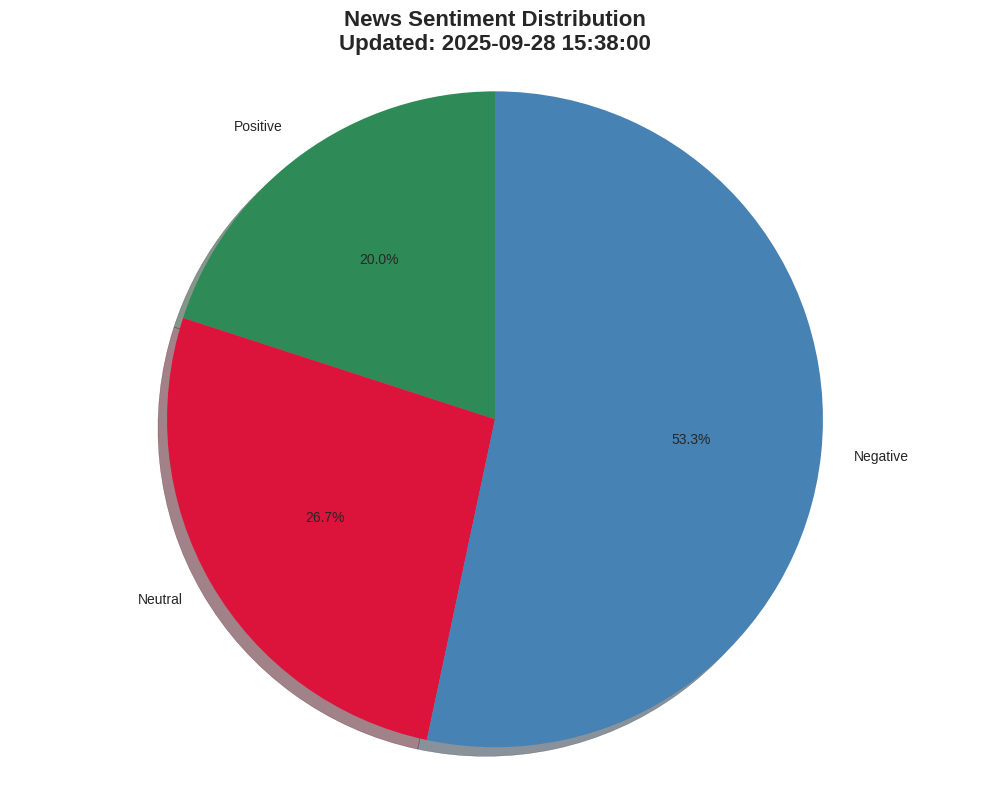

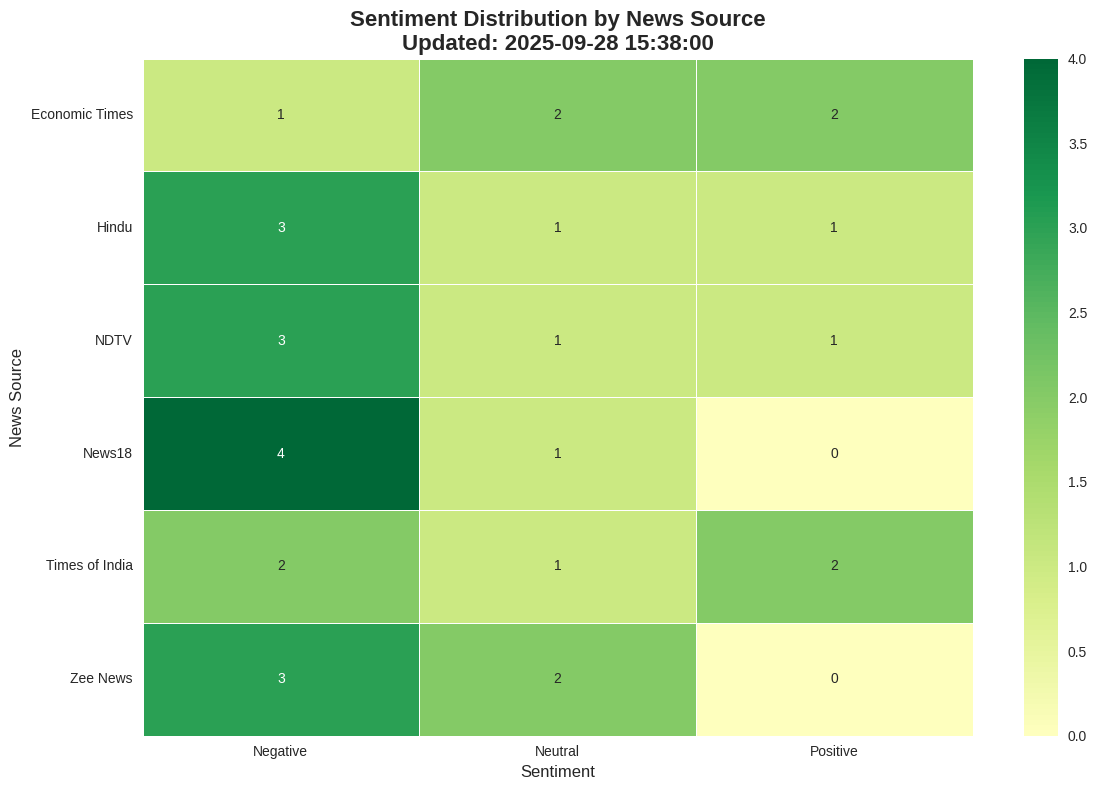

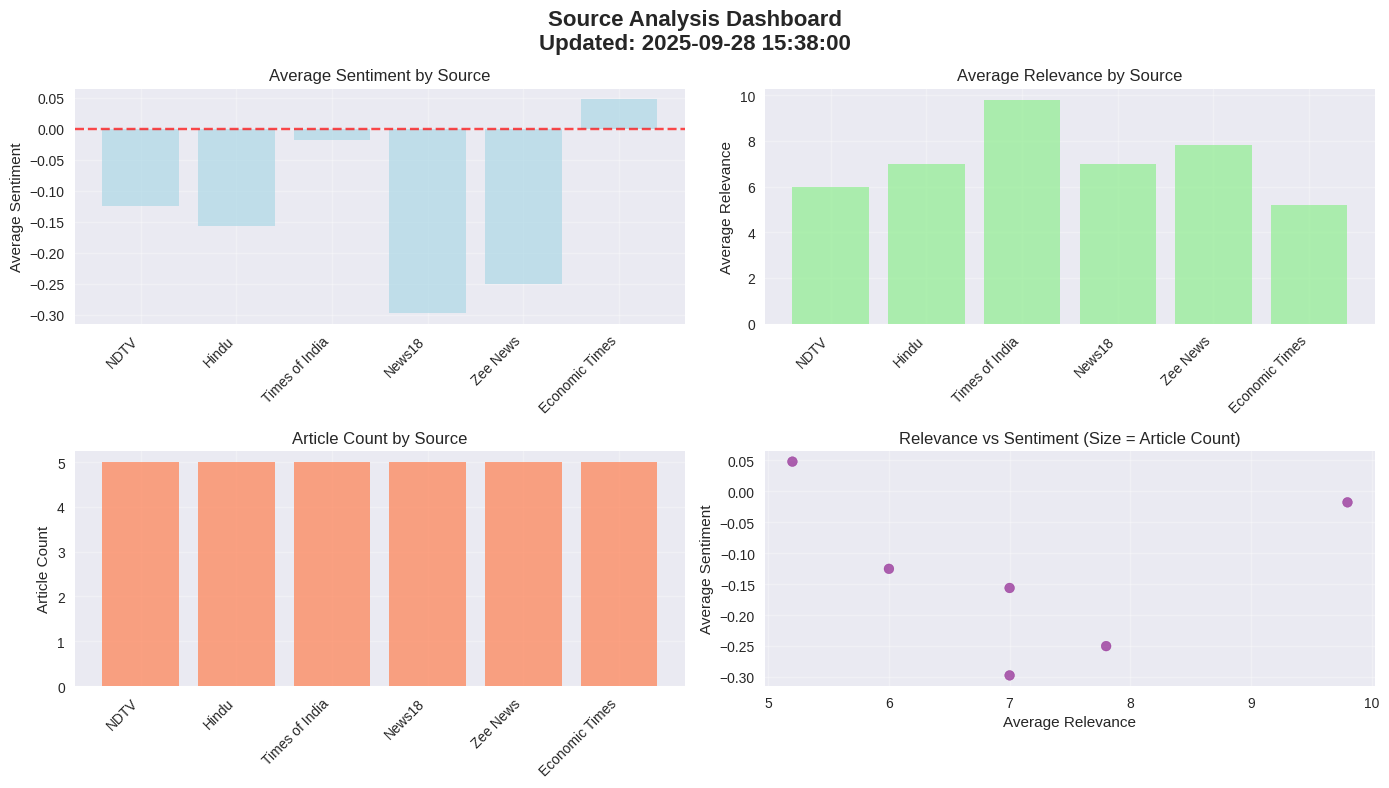


TOP ARTICLES ANALYSIS - Updated: 2025-09-28 15:38:00

 TOP POSITIVE NEWS (5 articles):
------------------------------------------------------------
1. [NDTV] Toddler "Sold" For Rs 45,000 Rescued From UP, 5 Detained: Police...
   Sentiment Score: 0.613

2. [Times of India] Maharashtra, West Bengal recorded highest number of foreign visitors in 2024: Go...
   Sentiment Score: 0.509

3. [Hindu] Women’s World Cup | Women In Blue dare to dream in pursuit of history...
   Sentiment Score: 0.229

4. [Economic Times] Karur deaths: Police file case against Vijay's party...
   Sentiment Score: 0.201

5. [Economic Times] India-China trade hits a ‘rare’ roadblock...
   Sentiment Score: 0.150


 TOP NEGATIVE NEWS (5 articles):
------------------------------------------------------------
1. [News18] 'Govt Stands With Victims': DMK's Kanimozhi Urges People To Wait For Probe In Ka...
   Sentiment Score: -0.539

2. [NDTV] '1 Cop For 50 People': Tamil Nadu Police Defends Deployment At TVK Chief Vijay's

In [ ]:
# Global variables for data storage
all_scraped_data = []
processing_active = True
iteration_count = 0

def real_time_news_sentiment_analysis():
    """Main real-time processing function"""
    global all_scraped_data, processing_active, iteration_count

    print(" Starting Real-Time News Sentiment Analysis...")
    print(" To stop the process, interrupt the kernel or set processing_active = False")
    print(" Scraping interval: 10 seconds")
    print(" Dashboard update: Every cycle")
    print(f" Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("="*80)

    start_time = time.time()

    try:
        while processing_active:
            iteration_count += 1
            cycle_start_time = time.time()

            print(f"\n Processing Cycle {iteration_count} - {datetime.now().strftime('%H:%M:%S')}")

            try:

                print(" Scraping news from multiple sources...")
                raw_articles = scrape_all_sources()

                if not raw_articles:
                    print(" No new articles found in this cycle")
                    time.sleep(10)
                    continue


                print(f" Processing {len(raw_articles)} articles with sentiment analysis...")
                processed_articles = process_articles_with_sentiment(raw_articles)

                if not processed_articles:
                    print(" No articles processed successfully")
                    time.sleep(10)
                    continue


                all_scraped_data.extend(processed_articles)


                if len(all_scraped_data) > 500:
                    all_scraped_data = all_scraped_data[-500:]


                print("Creating PySpark DataFrame...")
                df_spark = create_spark_dataframe(processed_articles)

                if df_spark.count() == 0:
                    print(" Empty DataFrame created")
                    time.sleep(10)
                    continue


                print("Performing PySpark analytics...")
                analytics_results = analyze_with_pyspark(df_spark)

                if not analytics_results:
                    print("  Analytics failed")
                    time.sleep(10)
                    continue


                print(" Updating dashboard...")
                create_comprehensive_dashboard(analytics_results)


                cycle_time = time.time() - cycle_start_time
                total_time = time.time() - start_time

                print(f"\nCycle {iteration_count} completed successfully!")
                print(f"Cycle time: {cycle_time:.1f}s | Total runtime: {total_time/60:.1f}min")
                print(f"Total articles collected: {len(all_scraped_data)}")
                print(f" Next update in 10 seconds...")


                time.sleep(10)

            except KeyboardInterrupt:
                print("\n Process interrupted by user")
                processing_active = False
                break

            except Exception as e:
                print(f" Error in processing cycle {iteration_count}: {str(e)}")
                print(" Continuing to next cycle...")
                time.sleep(10)
                continue

    except KeyboardInterrupt:
        print("\n Real-time processing stopped by user")
        processing_active = False
    except Exception as e:
        print(f" Fatal error in main loop: {str(e)}")
        processing_active = False
    finally:
        total_runtime = time.time() - start_time
        print(f"\n FINAL SUMMARY:")
        print(f"  Total runtime: {total_runtime/60:.1f} minutes")
        print(f"Completed cycles: {iteration_count}")
        print(f"Total articles collected: {len(all_scraped_data)}")
        print(f" Processing stopped at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print("="*80)


real_time_news_sentiment_analysis()


#Exporting the Results


 REAL-TIME NEWS SENTIMENT ANALYSIS DASHBOARD
 Last Updated: 2025-09-28 15:38:43
 Total Articles Analyzed: 30


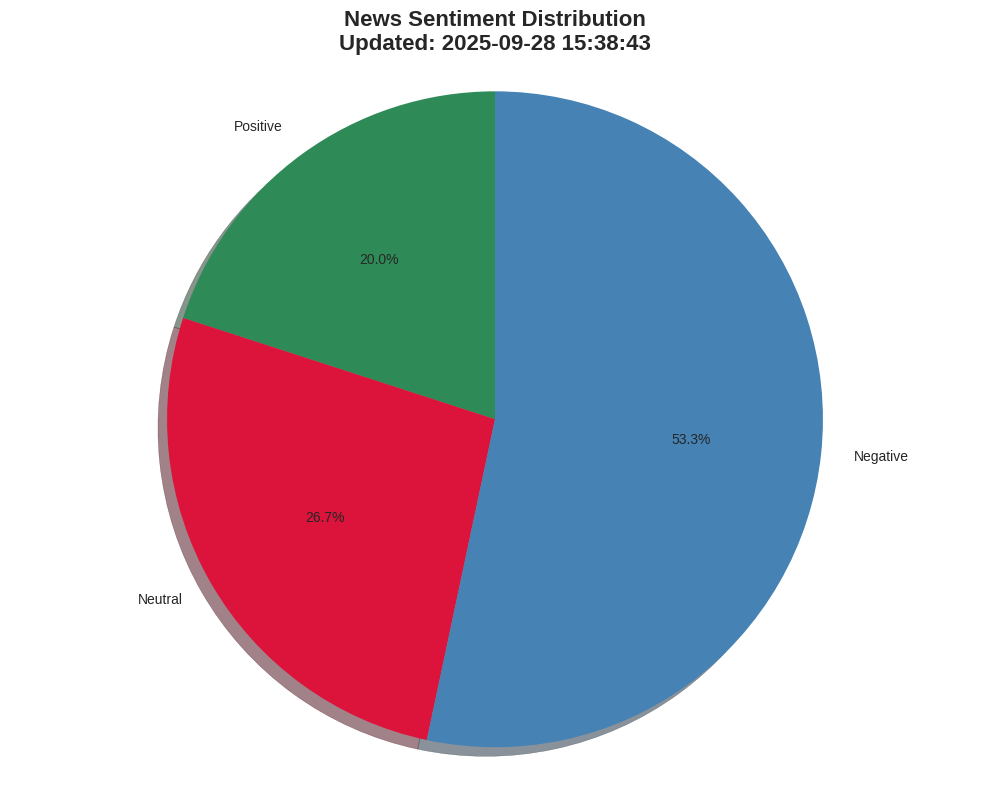

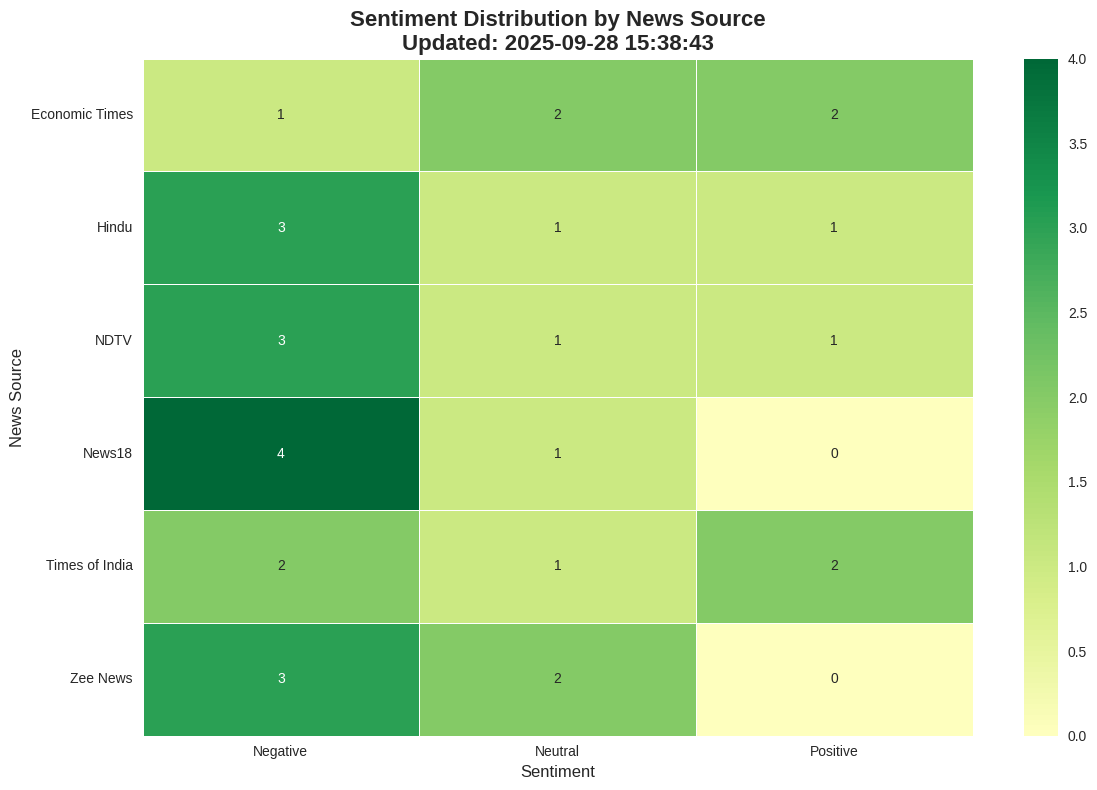

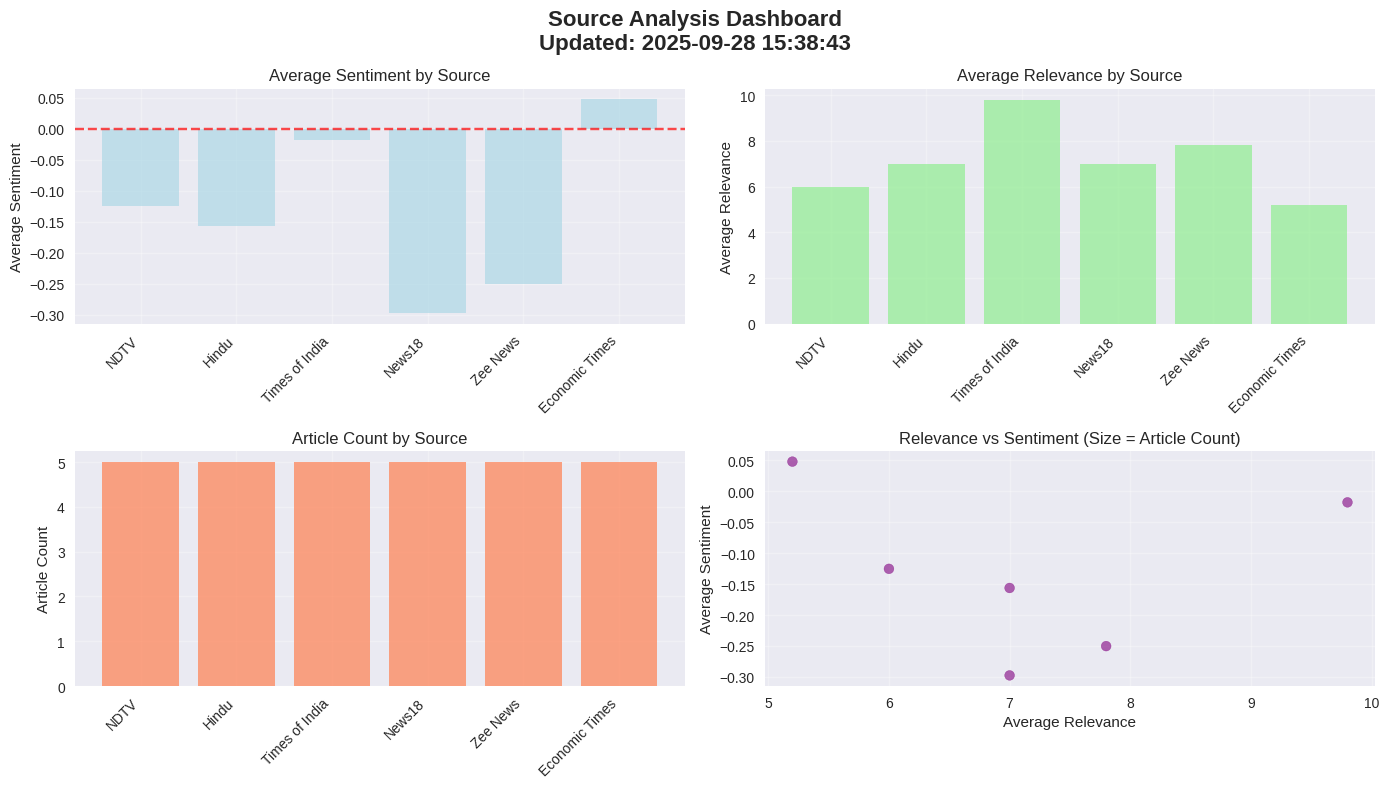


TOP ARTICLES ANALYSIS - Updated: 2025-09-28 15:38:43

 TOP POSITIVE NEWS (5 articles):
------------------------------------------------------------
1. [NDTV] Toddler "Sold" For Rs 45,000 Rescued From UP, 5 Detained: Police...
   Sentiment Score: 0.613

2. [Times of India] Maharashtra, West Bengal recorded highest number of foreign visitors in 2024: Go...
   Sentiment Score: 0.509

3. [Hindu] Women’s World Cup | Women In Blue dare to dream in pursuit of history...
   Sentiment Score: 0.229

4. [Economic Times] Karur deaths: Police file case against Vijay's party...
   Sentiment Score: 0.201

5. [Economic Times] India-China trade hits a ‘rare’ roadblock...
   Sentiment Score: 0.150


 TOP NEGATIVE NEWS (5 articles):
------------------------------------------------------------
1. [News18] 'Govt Stands With Victims': DMK's Kanimozhi Urges People To Wait For Probe In Ka...
   Sentiment Score: -0.539

2. [NDTV] '1 Cop For 50 People': Tamil Nadu Police Defends Deployment At TVK Chief Vijay's

In [ ]:
def export_final_results():
    """Export all collected data and final analysis"""
    global all_scraped_data

    if not all_scraped_data:
        print(" No data to export!")
        return

    print(" Exporting final results...")
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    try:
        # Create final DataFrame
        df_final = pd.DataFrame(all_scraped_data)

        # Export to CSV
        csv_filename = f"news_sentiment_analysis_{timestamp}.csv"
        df_final.to_csv(csv_filename, index=False, encoding='utf-8')
        print(f"Raw data exported to: {csv_filename}")

        # Create PySpark DataFrame for final analysis
        df_spark_final = create_spark_dataframe(all_scraped_data)
        final_analytics = analyze_with_pyspark(df_spark_final)

        # Export analytics summary
        if final_analytics:
            summary_filename = f"analytics_summary_{timestamp}.json"

            # Convert PySpark Row objects to dictionaries for JSON serialization
            exportable_analytics = {}

            for key, value in final_analytics.items():
                if key in ['source_sentiment', 'avg_sentiment_by_source', 'hourly_sentiment']:
                    # Convert PySpark Row objects to dictionaries
                    exportable_analytics[key] = [row.asDict() for row in value]
                elif key in ['positive_articles', 'negative_articles']:
                    # Convert PySpark Row objects to dictionaries
                    exportable_analytics[key] = [row.asDict() for row in value]
                elif key == 'relevance_stats':
                    # Convert PySpark Row to dictionary
                    exportable_analytics[key] = value.asDict() if value else {}
                else:
                    exportable_analytics[key] = value

            with open(summary_filename, 'w', encoding='utf-8') as f:
                json.dump(exportable_analytics, f, indent=2, ensure_ascii=False, default=str)
            print(f"Analytics summary exported to: {summary_filename}")

        # Final comprehensive dashboard
        print(" Generating final comprehensive dashboard...")
        create_comprehensive_dashboard(final_analytics)

        # Additional detailed analysis
        print("\n" + "="*80)
        print(" FINAL COMPREHENSIVE ANALYSIS")
        print("="*80)

        # Overall statistics
        total_articles = len(all_scraped_data)
        sources_count = len(df_final['source'].unique())

        sentiment_counts = df_final['sentiment'].value_counts()
        avg_sentiment_score = df_final['sentiment_score'].mean()
        avg_relevance_score = df_final['relevance_score'].mean()

        print(f"OVERALL STATISTICS:")
        print(f"   • Total Articles Analyzed: {total_articles}")
        print(f"   • Number of Sources: {sources_count}")
        print(f"   • Average Sentiment Score: {avg_sentiment_score:.3f}")
        print(f"   • Average Relevance Score: {avg_relevance_score:.3f}")
        print(f"   • Processing Duration: {iteration_count} cycles")

        print(f"\n SENTIMENT BREAKDOWN:")
        for sentiment, count in sentiment_counts.items():
            percentage = (count/total_articles)*100
            print(f"   • {sentiment}: {count} articles ({percentage:.1f}%)")

        print(f"\n TOP PERFORMING SOURCES:")
        source_stats = df_final.groupby('source').agg({
            'sentiment_score': 'mean',
            'relevance_score': 'mean',
            'title': 'count'
        }).round(3)
        source_stats.columns = ['Avg_Sentiment', 'Avg_Relevance', 'Article_Count']
        source_stats = source_stats.sort_values('Avg_Sentiment', ascending=False)
        print(source_stats.to_string())

        # Export source statistics
        source_stats_filename = f"source_statistics_{timestamp}.csv"
        source_stats.to_csv(source_stats_filename)
        print(f"\n Source statistics exported to: {source_stats_filename}")

        # Memory cleanup
        df_spark_final.unpersist()

        print(f"\n🎉 Export completed successfully!")
        print(f"Files generated:")
        print(f"   • {csv_filename}")
        print(f"   • {summary_filename}")
        print(f"   • {source_stats_filename}")

    except Exception as e:
        print(f" Error during export: {str(e)}")

# Run the export function
export_final_results()
